# Quickstart Guide

This tutorial gives you a very quick overview of some of the core features of AMPERE. This is not an exhaustive guide, just enough to get you started with the main ideas.

We start with a few imports required to get us up and running. Many of these imports could be delayed until later in this tutorial, but for now we'll just put them all here.

In [1]:
import sys
import numpy as np
import os
import ampere
from ampere.data import Spectrum, Photometry
from ampere.infer.emceesearch import EmceeSearch
from ampere.models import Model
from spectres import spectres
import pyphot
from emcee import moves

Before we do any inference, we have to define the model we want to do it with. AMPERE provides a base class `Model` in `ampere.models` that you should subclass. Here is a simple example; the generative model is a straight line, with simple uniform priors defined by a set of limits. 

In [2]:
class ASimpleModel(Model):
    '''This is a very simple model in which the flux is linear in wavelength.

    This model shows you the basics of writing a model for ampere

    '''
    def __init__(self, wavelengths, flatprior=True,
                 lims=np.array([[-10, 10],
                                [-10, 10]])):
        '''The model constructor, which will set everything up

        This method does essential setup actions, primarily things that 
        may change from one fit to another, but will stay constant throughout 
        the fit. This may be things like the grid of wavelengths to calculate
        the model output on, or establishing the dust opacities if involved.
        There are also several important variables it *MUST* define here
        '''
        self.wavelength = wavelengths
        self.npars = 2 #Number of free parameters for the model (__call__()). For some models this can be determined through introspection, but it is still strongly recommended to define this explicitly here. Introspection will only be attempted if self.npars is not defined.
        self.npars_ptform = 2 #Sometimes the number of free parameters is different when using the prior transform instead of the prior. In that case, self.npars_ptform should also be defined.
        #You can do any other set up you need in this method.
        #For example, we could define some cases to set up different priors
        #But that's for a slightly more complex example.
        #Here we'll just use a simple flat prior
        self.lims = lims
        self.flatprior = flatprior
        self.parLabels = ["slope", "intercept"]

    def __call__(self, slope, intercept, **kwargs):
        '''The model itself, using the callable class functionality of python.

        This is an essential method. It should do any steps required to 
        calculate the output fluxes. Once done, it should stop the output fluxes
        in self.modelFlux.
        '''
        self.modelFlux = slope*self.wavelength + intercept
        return {"spectrum":{"wavelength":self.wavelength, "flux": self.modelFlux}}

    def lnprior(self, theta, **kwargs):
        """The model prior probability distribution
        
        The prior is essential to most types of inference with ampere. The prior
        describes the relative weights (or probabilities if normalised) of different
        parameter combinations. 
        """
        slope = theta[0]
        #print(slope)
        intercept = theta[1]
        if self.flatprior:
            if (self.lims[0,0] < theta[0] < self.lims[0,1]) and (self.lims[1,0] < theta[1] < self.lims[1,1]):
                return 0
            else:
                return -np.inf
        else:
            raise NotImplementedError()
        

    def prior_transform(self, u, **kwargs):
        '''The prior transform, which takes samples from the Uniform(0,1) distribution to the desired distribution.

        This is only included for completeness and to demonstrate how a prior 
        transform function should look. This example only uses emcee for 
        fitting, which uses the lnprior function instead. Prior transforms are 
        required by nested-sampling codes and similar approaches.
        '''
        if self.flatprior:
            theta = np.zeros_like(u)
            return (self.lims[:,1] - self.lims[:,0]) * u + self.lims[:,0]
        else:
            raise NotImplementedError()

You will notice that the model has 4 methods; you could easily avoid some of these for your specific problem by hardcoding some things - for example, by making some of the attributes set in the constructor into class attributes. Similarly, we defined both `lnprior` and `prior_transform` methods here even though we will be using emcee later for our inference, which doesn't use the `prior_transform`.

Once we have got our model set up, we need to have some data that we want to interpret using it. Most of the time, you will have real data that you want to use, but in this case we're going to generate some synthetic data from our own model. This way, we can confirm that the model does what we want and test if the posterior estimates match well enough with our true parameter values.

In [3]:
""" Set up the inputs for the model """
""" wavelength grid """
wavelengths = 10**np.linspace(0.,1.9, 2000)

""" Choose some model parameters """
slope = 1. #Keep it super simple for now
intercept = 1.

#Now init the model:
model = ASimpleModel(wavelengths)
#And call it to produce the fluxes for our chosen parameters
result = model(slope, intercept)
model_flux = result['spectrum']['flux']

Now that we have generated the synthetic fluxes, we're going to turn that into synthetic photometry in two observing bands - WISE W1 and Spitzer MIPS 70 μm. This uses the `pyphot` package to compute the flux we would observe in these filters for a source with this spectrum. Then, we had noise assuming that our uncertainty is roughly 10% - a broadly representative value for the calibration uncertainty on infrared photometry.

In [4]:
#Now we create synthetic data:
#First photometry
filterName = np.array(['WISE_RSR_W1', 'SPITZER_MIPS_70']) #This is minimal, so we'll just have two bands well separated

libDir = ampere.__file__.strip('__init__.py') # '/home/peter/pythonlibs/ampere/ampere/'
libname = libDir + 'ampere_allfilters.hd5'
filterLibrary = pyphot.get_library(fname=libname)
filters = filterLibrary.load_filters(filterName, interp=True, lamb = wavelengths*pyphot.unit['micron'])
#Now we need to extract the photometry with pyphot
#first we need to convert the flux from Fnu to Flambda
flam = model_flux / wavelengths**2
modSed = []
for i, f in enumerate(filters):
    lp = f.lpivot.to("micron").value
    fphot = f.get_flux(wavelengths*pyphot.unit['micron'], flam*pyphot.unit['flam'], axis=-1).value
    print(fphot)
    modSed.append(fphot*lp**2)

modSed = np.array(modSed)

input_noise_phot = 0.1 #Fractional uncertainty
photunc = input_noise_phot * modSed #Absolute uncertainty
modSed = modSed + np.random.randn(len(filterName)) * photunc #Now perturb data by drawing from a Gaussian distribution

0.38407418618609507
0.014786373277291763


Now that we've got our synthetic photometry, we're going to create a `Photometry` object so that AMPERE can interact with it properly.

In [5]:
""" now set up ampere to try and fit the same stuff """
photometry = Photometry(filterName=filterName, value=modSed, uncertainty=photunc, photunits='Jy', libName=libname)
#print(photometry.filterMask)
photometry.reloadFilters(wavelengths)

['WISE_RSR_W1' 'SPITZER_MIPS_70']
Jy
<class 'str'>
Jy


Now we're also going to generate a synthetic *Spizter*/IRS mid-infrared spectrum to combine with the photometry. To do this, we will read in a spectrum that is packaged with AMPERE so that we get appropriate wavelength sampling, and resample our model spectrum to that sampling. Then we add some noise (again, assuming an uncertainty of 10%) and create `Spectrum` objects for AMPERE to work with.

In [6]:
#now we'll create a synthetic spectrum from the model fluxes, using a Spitzer IRS observation to get the wavelength sampling
dataDir = ampere.__file__.replace("__init__.py", "")+"../examples/test_data/"#os.getcwd() + '/PGQuasars/PG1011-040/'
print(dataDir)
specFileExample = 'cassis_yaaar_spcfw_14191360t.fits'
irsEx = Spectrum.fromFile(dataDir+specFileExample,format='SPITZER-YAAAR')
spec0 = spectres(irsEx[0].wavelength,wavelengths,model_flux)
spec1 = spectres(irsEx[1].wavelength,wavelengths,model_flux)

#And again, add some noise to it
input_noise_spec = 0.1
unc0 = input_noise_spec*spec0
unc1 = input_noise_spec*spec1
spec0 = spec0 + np.random.randn(len(spec0))*unc0
spec1 = spec1 + np.random.randn(len(spec1))*unc1

spec0 = Spectrum(irsEx[0].wavelength, spec0, unc0,"um", "Jy",calUnc=0.0025, scaleLengthPrior = 0.01) #, resampleMethod=resmethod)
spec1 = Spectrum(irsEx[1].wavelength, spec1, unc1,"um", "Jy",calUnc=0.0025, scaleLengthPrior = 0.01) #, resampleMethod=resmethod)

/home/psciclun/code/pythondev/ampere/ampere/../examples/test_data/
Spectrum has  [1. 2.]  chunks, breaking up the spectrum into separate chunks.


Model spectra have to be resampled to the same wavelength sampling for a proper comparison to the data. AMPERE lets you change how this is done, depending on how worried you are about things like flux conservation or speed. This model is pretty simple, however, so we will switch to the fast method which just interpolates the model.

In [7]:
#Now let's try changing the resampling method so it's faster
#This model is very simple so exact flux conservation is not important
resmethod = "fast" #"exact"#"fast"#
spec0.setResampler(resampleMethod=resmethod)
spec1.setResampler(resampleMethod=resmethod)

Using fast resampling
Using fast resampling


Now that we have our synthetic data, we can put them together in a list to pass to AMPERE. To keep things simple, we will only use one of the two parts of the *Spitzer* spectrum, so the other one is commented out here. See what happens if you include both!

In [8]:
dataset = [photometry,
           #spec0, #Fitting spectra is slow because it needs to do a lot of resampling
           spec1   #As a result, we're leaving some of them out
           ]

Just before we start actually running anything, we'll make a quick aside to point out that when using emcee you can exploit the [moves](https://emcee.readthedocs.io/en/stable/user/moves/) interface to adjust the proposal a bit depending on your specific problem.

In [9]:
#Ampere exposes acces to emcee's moves interface. This can be useful if the posterior turns out to not be well behaved - the default move only deals well with posteriors that are monomodal and approximately Gaussian. Here's an example that usually deals a bit better with posteriors that don't meet these criteria:
m = [(moves.DEMove(), 0.8),
    (moves.DESnookerMove(), 0.2),
    ]

Now we can create our inference object, telling it what our model and dataset are. Since this is using emcee, we also have to tell it how many walkers to use. Changing the moves is optional.

In [10]:
#Now we set up the optimizer object:
optimizer = EmceeSearch(model=model, data=dataset, nwalkers=100, moves=m, vectorize = False)

2023-02-05 15:34:31,641 [MainThread  ] [INFO    ]  Welcome to ampere
2023-02-05 15:34:31,642 [MainThread  ] [INFO    ]  Setting up your inference problem:
2023-02-05 15:34:31,642 [MainThread  ] [INFO    ]  You are using Affine-invariance ensemble MCMC with emcee
2023-02-05 15:34:31,644 [MainThread  ] [INFO    ]  You have 2 items in your dataset
2023-02-05 15:34:31,644 [MainThread  ] [INFO    ]  This model has 2 parameters.
2023-02-05 15:34:31,645 [MainThread  ] [INFO    ]  There are also 3 parameters for the noise model
2023-02-05 15:34:31,646 [MainThread  ] [INFO    ]  Hence, there are a total of 5 parameters to sample
2023-02-05 15:34:31,647 [MainThread  ] [INFO    ]  The parameter names are:
2023-02-05 15:34:31,647 [MainThread  ] [INFO    ]  slope
2023-02-05 15:34:31,649 [MainThread  ] [INFO    ]  intercept
2023-02-05 15:34:31,650 [MainThread  ] [INFO    ]  calVar
2023-02-05 15:34:31,651 [MainThread  ] [INFO    ]  cov scale factor
2023-02-05 15:34:31,651 [MainThread  ] [INFO    ]  c

You also need to pass an initial guess to the inference object. This will be used as a starting point for optimisation with `scipy.optimise.minimise()` and then the walkers will be initialised in a compact ball around the end point of the optimsiation. We will take a fairly simple guess since this is a simple model. Even though our model has 2 free parameters, you will see that there are a few extra values in the guess; this is because the `Spectrum` has a noise model which includes a few extra parameters to model extra correlated noise. 

In [11]:
guess = [
        [1, 1, #The parameters of the model
         #1.0, 0.1, 0.1, #Each Spectrum object contains a noise model with three free parameters
         #The first one is a calibration factor which the observed spectrum will be multiplied by
         #The second is the fraction of correlated noise assumed
         #And the third is the scale length (in microns) of the correlated component of the noise
         1.0 ,0.1, 0.1
       ] #
        + np.random.rand(optimizer.npars)*[1,1,
                                           #1,1,1,
                                           1,1,1
                                           ]
        for i in range(optimizer.nwalkers)]

Now we can tell emcee to go do its thing. This will start with the optimisation with `scipy`, then emcee will take over to sample. Since this is a relatively simple model, we will stick with a relatively small number of samples and a short burn-in. The burn-in is the first part of the sampling during which we hope the chains will reach equilibrium with the posterior distribution, and will be discarded before determining the credible interval.

In [12]:
#Then we tell it to explore the parameter space
optimizer.optimise(nsamples = 150, burnin=100, guess=guess
                   )

2023-02-05 15:34:31,689 [MainThread  ] [INFO    ]  Preparing to sample
2023-02-05 15:34:31,690 [MainThread  ] [INFO    ]  Searching for approximate MAP solution as starting point for MCMC
2023-02-05 15:34:31,691 [MainThread  ] [INFO    ]  Selecting start point for scipy.minimize
2023-02-05 15:34:31,693 [MainThread  ] [INFO    ]  Using scipy.minimize to find approximate MAP solution
2023-02-05 15:34:31,694 [MainThread  ] [INFO    ]  starting from position: [1.98639834 1.24260514 1.93075365 0.1871981  0.13312515]


/home/psciclun/anaconda3/envs/ampere_dev_pyphotmain/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/psciclun/anaconda3/envs/ampere_dev_pyphotmain/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/psciclun/anaconda3/envs/ampere_dev_pyphotmain/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/psciclun/anaconda3/envs/ampere_dev_pyphotmain/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/psciclun/anaconda3/envs/ampere_dev_pyphotmain/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


2023-02-05 15:34:33,525 [MainThread  ] [INFO    ]  Minimization complete, final position: [0.9982910840369967, 0.19165941572295253, 0.8392012371837135, 0.02279982247575768, 0.03292558686016565] 
2023-02-05 15:34:33,528 [MainThread  ] [INFO    ]  Starting to sample: 
2023-02-05 15:34:33,529 [MainThread  ] [INFO    ]  Each walker will produce 150 samples, of which the first 100 will be discarded as burn-in


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:46<00:00,  1.11s/it]


Once this is complete, we can tell AMPERE to run some post-processing, which will compute some convergence criteria, and issue a warning if there is strong evidence that the MCMC didn't converge, then determine the point estimate and credible interval for all the parameters. Finally, it will produce a few useful diagnostic plots.

N/50 = 3;
tau: [ 8.08440281 10.12500418 17.39967465  8.82085328 16.50080519]


2023-02-05 15:37:20,956 [MainThread  ] [INFO    ]  Rhat = 1.000 <= 1.050 
2023-02-05 15:37:20,960 [MainThread  ] [INFO    ]  MAP solution:
2023-02-05 15:37:20,962 [MainThread  ] [INFO    ]  slope  = 1.01183
2023-02-05 15:37:20,963 [MainThread  ] [INFO    ]  intercept  = 0.48921
2023-02-05 15:37:20,965 [MainThread  ] [INFO    ]  calVar  = 0.99455
2023-02-05 15:37:20,966 [MainThread  ] [INFO    ]  cov scale factor  = 0.00155
2023-02-05 15:37:20,967 [MainThread  ] [INFO    ]  cov scale length  = 0.00290
2023-02-05 15:37:20,969 [MainThread  ] [INFO    ]  Median and confidence intervals for parameters in order:
2023-02-05 15:37:20,970 [MainThread  ] [INFO    ]  slope  = 1.01505 + 0.01896 - 0.02096
2023-02-05 15:37:20,971 [MainThread  ] [INFO    ]  intercept  = 0.40705 + 0.37190 - 0.37578
2023-02-05 15:37:20,973 [MainThread  ] [INFO    ]  calVar  = 0.99451 + 0.00461 - 0.00492
2023-02-05 15:37:20,974 [MainThread  ] [INFO    ]  cov scale factor  = 0.06147 + 0.05640 - 0.04265
2023-02-05 15:37:2

N/50 = 3;
tau: [ 8.08440281 10.12500418 17.39967465  8.82085328 16.50080519]
/home/psciclun/code/pythondev/ampere/ampere/infer/mixins.py:627: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(d.covMat))


Setting plotting parameters for photometry data set.
Setting plotting parameters for photometry data set.


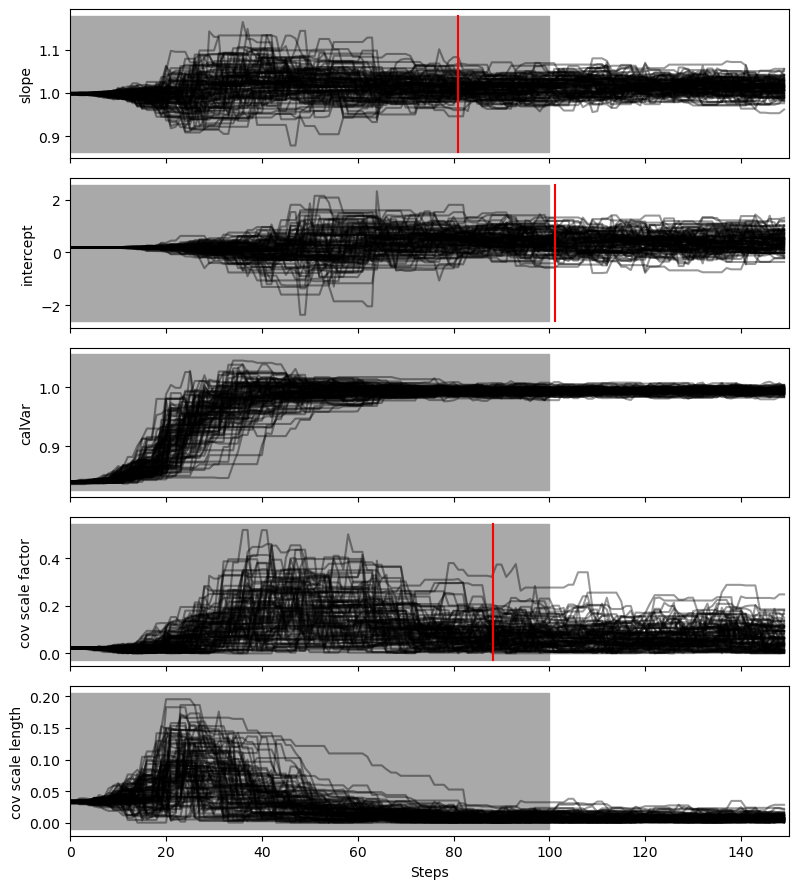

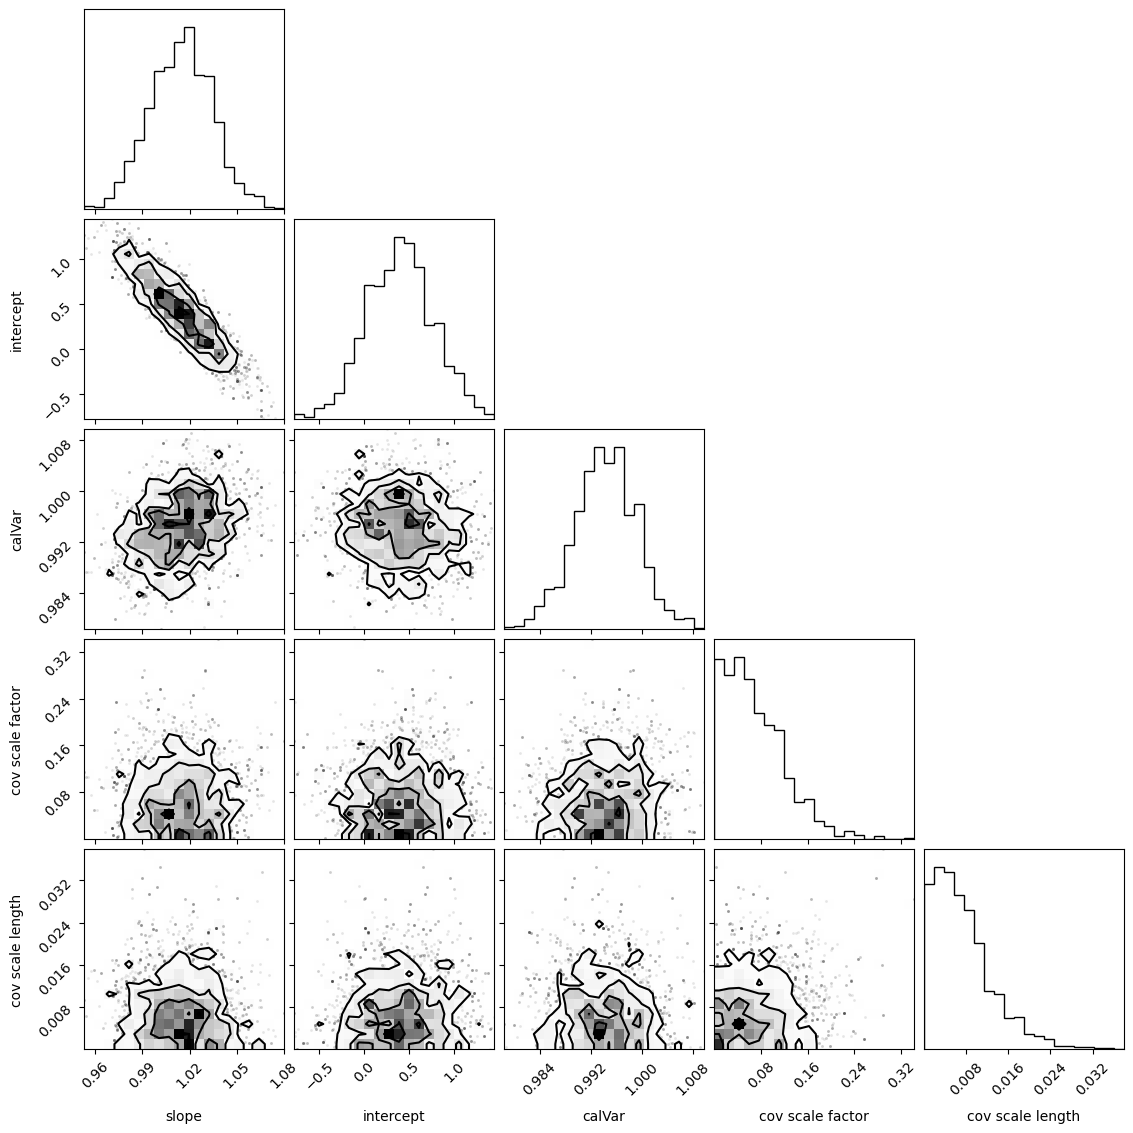

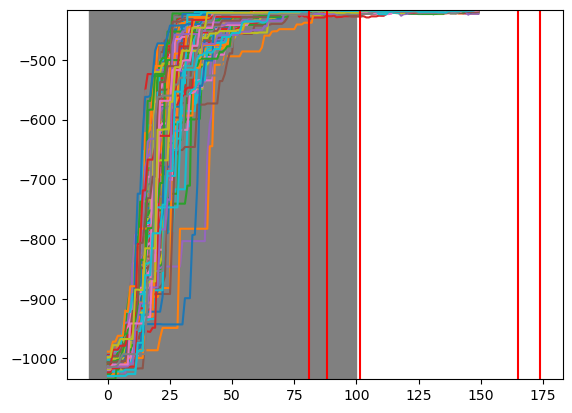

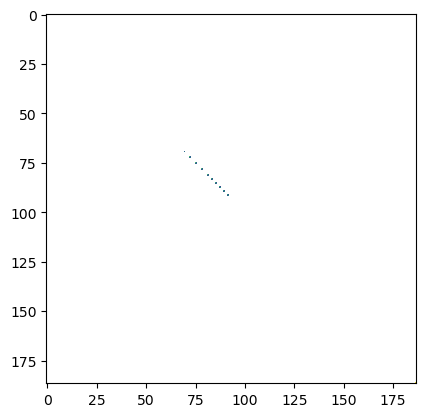

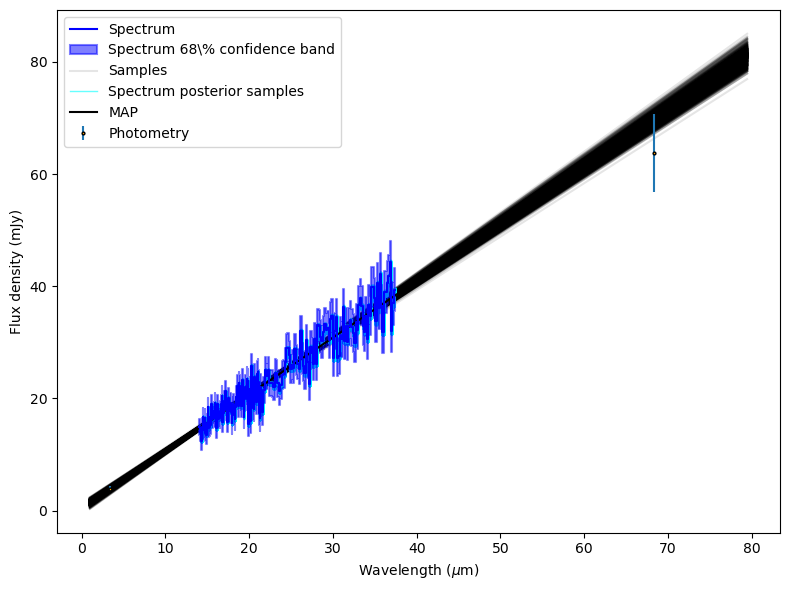

In [13]:
optimizer.postProcess() #now we call the postprocessing to produce some figures

You can see from the plots that the results look pretty good, even for such short MCMC chains. In case you want to continue analysing the results or produce new plots, we recommend that you pickle the inference object too.

This is just a quick overview of what AMPERE can do for you. Take a look at the other tutorials, or at some of the examples in the [github repository](https://github.com/ICSM/ampere) for more. 